In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

Initializing T1027-D1 ...
Results already exist
Casp ID: T1027-D1 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
UniProt ID: Q9BLZ2
Slope: -47.96330388102577, Intercept: 114.6029020942982 R-squared: 0.6228605485266521


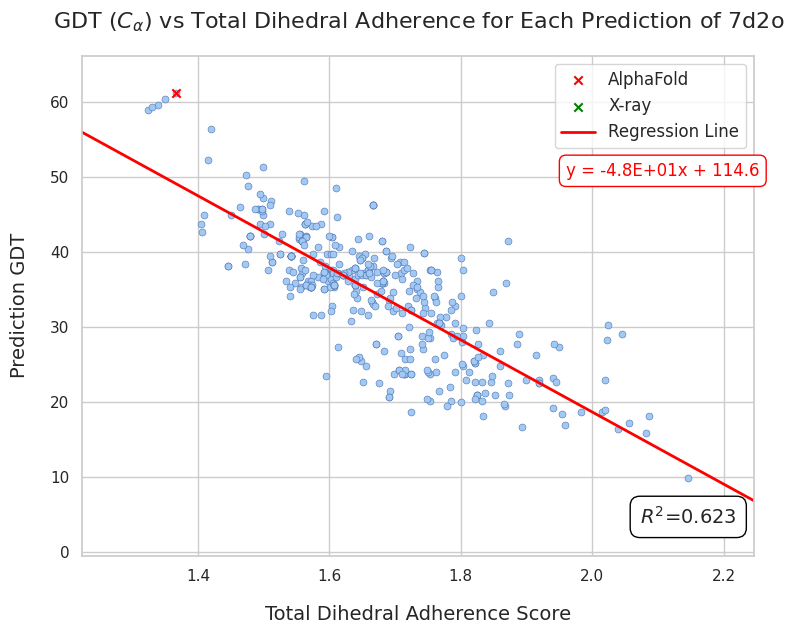

In [7]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = [
  'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[6], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                      mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
# da.load_results()
# da.compute_das()
# da.test_pdbmine_conn()
# da.query_pdbmine()
da.load_results_da()
da.filter_nas(quantile=0.8)
# rsquared, pearsonr = da.test_correlation()
# da.filter_nas(quantile=0.7)
# results = pd.concat([q.results for q in da.queries])
# print(results.groupby('phi').size().sort_index(ascending=False).head())
# results.describe().loc[['min','max'], ['phi','psi']]
# print(da.xray_phi_psi.describe().loc[['min','max'], ['phi','psi']])
# da.phi_psi_predictions.describe().loc[['min','max'], ['phi','psi']]
# da.plot_da_for_seq()
# da.plot_dist_kde(percentile=0.50)
# both = da.plot_res_vs_da()
# da.plot_da_vs_gdt()
da.plot_da_vs_gdt_simple()
# print(da.grouped_preds.da_na.describe())
# print(da.grouped_preds[da.grouped_preds.da_na > da.grouped_preds.da_na.quantile(0.9)].shape)
# da.plot_res_vs_da(da.protein_ids[0], highlight_res=((159,163),(187,191),(373,377)), legend_loc='upper left', text_loc='left')
# print((~np.isnan(da.grouped_preds_da.values)).sum(axis=1).mean())
# print((~np.isnan(da.grouped_preds_da.values)).sum(axis=1).std())
# da.plot_heatmap(fillna=False, fillna_row=False)
# print(da.grouped_preds[da.grouped_preds.protein_id==da.get_id('337_5')].RMS_CA)
# rmsds, n, rmsd_inner = da.split_and_compute_rmsd(pred_id=da.protein_ids[0], split=[(48,48),(49,49),(76, 76),(106,106),(107,107)])
# rmsds, n, rmsd_inner = da.split_and_compute_rmsd(pred_id=da.protein_ids[0], split=[(161,161), (189,189), (362,375)])

In [49]:
proteins = [
  'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
for protein in proteins:
    try:
        da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                               mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda')
        # da.query_pdbmine()
        # da.compute_structures(replace=True)
        da.load_results()
        da.compute_das(replace=True)
    except Exception as e:
        print(f"{protein} - Error: {e}")

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658
0/372: KEFWNLD
	Win 4: FWNL - 388 samples
	Win 5: EFWNL - 25 samples
	Win 6: EFWNLD - 0 samples
	Win 7: KEFWNLD - 0 samples
	Weighted n samples: 538.0
	478 predictions
	Xray DA: [5.97061805] Pred DA: 43.96713513683796
1/372: EFWNLDK
	Win 4: WNLD - 291 samples
	Win 5: FWNLD - 8 samples
	Win 6: FWNLDK - 0 samples
	Win 7: EFWNLDK - 0 samples
	Weighted n samples: 339.0
	478 predictions
	Xray DA: [6.82231536] Pred DA: 51.58035031899081
2/372: FWNLDKN
	Win 4: NLDK - 2550 samples
	Win 5: WNLDK - 42 samples
	Win 6: WNLDKN - 0 samples
	Win 7: FWNLDKN - 0 samples
	Weighted n samples: 2802.0
	478 predictions
	Xray DA: [12.62324305] Pred DA: 54.897564303906755
3/372: WNLDKNL
	Win 4: LDKN - 2427 samples
	Win 5: NLDKN - 95 samples
	Win 6: NLDKNL - 8 samples
	Win 7: WNLDKNL - 0 samples
	Weighted n samples: 3053.0
	478 predictions
	Xray DA: [3.48757564] Pred DA: 56.12489581327

In [ ]:
from lib.fit_model_on_multiple import fit_lr, plot_md_vs_rmsd
import os
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# model, grouped_preds = fit_model_on_multiple(['T1056', 'T1038', 'T1025', 'T1028'], WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, n_comp=2000)
model, grouped_preds = fit_lr(
    ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025'],
    # ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028'],
    [4,5,6,7], [1,32,64,128],
    PDBMINE_URL, PROJECT_DIR,
    n_comp=2000,
)
plot_md_vs_rmsd(grouped_preds, axlims=((0,60), (0,80)))